In [1]:
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams.update({'font.size': 22})


from matplotlib import rc
rc('text', usetex=True)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
###########################################
def z_avg(data_u):
    import numpy as np
    m,n,p = data_u.shape
    const=1.0/float(m)
    data_avg_u = np.zeros((n,p))
    
    for idz in range(m):
        data_avg_u[:,:]+= data_u[idz,:,:]
        
    data_avg_u *= const
    return data_avg_u
#############################################

#############################################

def zy_avg(data_u):
    import numpy as np
    m,n,p = data_u.shape
    const=1.0/float(m*n)
    data_avg_ux = np.zeros((p))
    
    for idz in range(m):
        for idy in range(n):
            data_avg_ux[:]+= data_u[idz,idy,:]
        
    data_avg_ux *= const
    return data_avg_ux
############################################
###################################################################
Nx,Ny,Nz=0,0,0
yD = []
def htps_turbine_reader(Pathname,D,if_disc,filebase,sigma_list):
    global Nx, Ny, Nz, yD

    if not if_disc:
        filename=Pathname+'/'+filebase+'_spanwise.out'
        Nx,Ny,Nz = 513,8,257
    else:
        filename=Pathname+'/'+filebase+'_disc.out'
        Nx,Ny,Nz = 513,8,61*3
        
    data=np.loadtxt(filename,skiprows=1,usecols=(1,2,3))
    Nyz,N_slice = Ny*Nz,Nx*Ny*Nz
    data_x1,data_y1,data_z1 = data[0:N_slice,0], data[0:N_slice,1],data[0:N_slice,2]
    # first slot of reshape: 1d --> 2d
    sp,s,sy= (Nyz,Nx),(Nz,Ny,Nx),(Nz,Ny)
    data_x1rs, data_y1rs, data_z1rs = data_x1.reshape(sp,order='F'),data_y1.reshape(sp,order='F'),data_z1.reshape(sp,order='F')

# first slot of reshape: 2d --> 3d
# the array data[] needs to sliced
# Have TKE [0] and dissipation [1] and uvms [2] data 
    data_x1rst,data_y1rst,data_z1rst = np.zeros(s),np.zeros(s),np.zeros(s)
    temp = np.zeros(sy)
# broadcasting of the arrays are necessary in order to get the data_x1rs fit into data_x1rst
    for idx in range(Nx):
        temp1,temp2,temp3 = data_x1rs[:,idx],data_y1rs[:,idx],data_z1rs[:,idx]
        data_x1rst[:,:,idx],data_y1rst[:,:,idx],data_z1rst[:,:,idx] = temp1.reshape(sy,order='F'),temp2.reshape(sy,order='F'),temp3.reshape(sy,order='F')

# statistical z_averages from the data 
################################################################################
    datax1_avg,datay1_avg,dataz1_avg = z_avg(data_x1rst),z_avg(data_y1rst),z_avg(data_z1rst)
    
## Gaussian Filtering
    dummy = gaussian_filter1d(datax1_avg[0,:],sigma=2.5)
    datax1_avg_smooth = np.zeros((Ny,len(dummy)))
    datay1_avg_smooth = np.zeros((Ny,len(dummy)))
    dataz1_avg_smooth = np.zeros((Ny,len(dummy)))

    for i in range(Ny):
        datax1_avg_smooth[i,:] = gaussian_filter1d(datax1_avg[i,:],sigma=sigma_list[0])
        datay1_avg_smooth[i,:] = gaussian_filter1d(datay1_avg[i,:],sigma=sigma_list[1])
        dataz1_avg_smooth[i,:] = gaussian_filter1d(dataz1_avg[i,:],sigma=sigma_list[2])
        
    # location of y stations
    y = np.array([-0.95,-0.9,-0.8,-0.6,-0.4,0.0,0.5,0.875]) #y = np.linspace(-1.0,1.0,Ny,endpoint=True)
    yD = (1+y)/D
  
    return datax1_avg_smooth,datay1_avg_smooth,dataz1_avg_smooth     
        

In [2]:
### Array Initialization ##
Case_list = ['PSU_TSR_3','PSU_NBC2','PSU_TSR_8']
Case = ['TSR = 3, $s_x$ = 7D','TSR = 5, $s_x$ = 7D','TSR = 8, $s_x$ = 7D','TSR = 5, $s_x$ = 3.5D']
Ncase = len(Case_list)

Nx,Ny =513,8

slist = [5.05,5.05,5.05]
tke,diss,uavg = np.zeros((Ncase,Ny,Nx)),np.zeros((Ncase,Ny,Nx)),np.zeros((Ncase,Ny,Nx))
tke_disc,diss_disc,uavg_disc = np.zeros((Ncase,Ny,Nx)),np.zeros((Ncase,Ny,Nx)),np.zeros((Ncase,Ny,Nx))

for i, case in enumerate(Case_list):
    tke[i,:,:],diss[i,:,:],_ = htps_turbine_reader(case,D=0.4,if_disc=False,filebase='tke',sigma_list=slist)
    uavg[i,:,:],_,_ = htps_turbine_reader(case,D=0.4,if_disc=False,filebase='avg',sigma_list=slist)
    tke_disc[i,:,:],diss_disc[i,:,:],_ = htps_turbine_reader(case,D=0.4,if_disc=True,filebase='tke',sigma_list=slist)
    uavg_disc[i,:,:],_,_ = htps_turbine_reader(case,D=0.4,if_disc=True,filebase='avg',sigma_list=slist)

## Plot length scales for different cases

Text(0.5, 1.0, '')

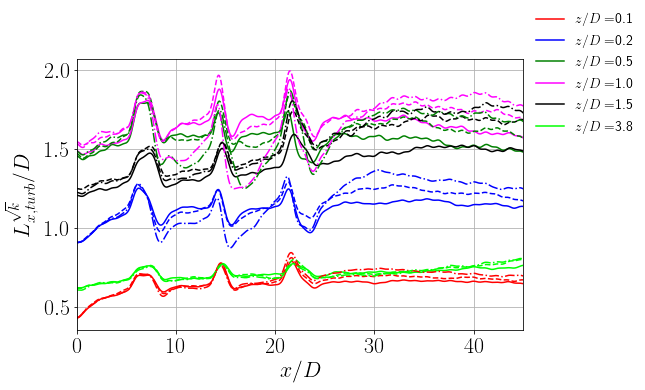

In [3]:
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams.update({'font.size': 22})

from matplotlib import rc
rc('text', usetex=True)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def label_gen(yD,k,i):
    if(i==0):
        labelx='$z/D = $%2.1f'%yD[k]
    else:
        labelx=None
    return labelx


#############
x = np.linspace(0.0,6.0*np.pi,Nx) ## x location
##############
eps = 1e-4
Lturb = np.sqrt(2/3)*tke**1.5/(diss+eps)
#Lturb = tke
D = 0.4

colors = ['red','blue','green','magenta','black','lime']
linestyle = ['-','--','-.','.']
linewidth = [3.0,3.0,3.0,6.0]

turb_width = [7,14,21]
y_turb_width = [0.55,0.55,0.55]
fig1 = plt.figure(figsize=(8,5))

for i in range(len(Case_list)):
    labelx = label_gen(yD,0,i)
    plt.plot(x/D,Lturb[i,1,:],color=colors[0],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,1,i)
    plt.plot(x/D,Lturb[i,2,:],color=colors[1],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,2,i)
    plt.plot(x/D,Lturb[i,3,:],color=colors[2],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,3,i)
    plt.plot(x/D,Lturb[i,4,:],color=colors[3],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,4,i)
    plt.plot(x/D,Lturb[i,5,:],color=colors[4],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,-2,i)
    plt.plot(x/D,Lturb[i,-2,:],color=colors[-1],linestyle=linestyle[i],label=labelx)
#    plt.scatter(turb_width,y_turb_width,color='green',marker='x',s=200,linewidth=3.0)
plt.xlim([0,45])
#plt.ylim([0.5,2.01])
plt.xlabel(r'$x/D$')
plt.ylabel(r'$L^{\sqrt{k}}_{x,turb}/D$')
plt.grid(True)
plt.legend(loc='best',bbox_to_anchor=(1,0.675),frameon=False,fontsize=14)
plt.title('')




Text(0.5, 1.0, '')

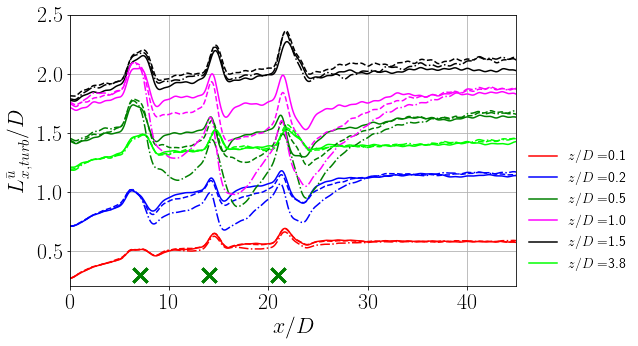

In [4]:
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams.update({'font.size': 22})

from matplotlib import rc
rc('text', usetex=True)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def label_gen(yD,k,i):
    if(i==0):
        labelx='$z/D = $%2.1f'%yD[k]
    else:
        labelx=None
    return labelx


#############
x = np.linspace(0.0,6.0*np.pi,Nx) ## x location
##############
eps = 1e-4
Lturb = 0.1*uavg*tke/(diss+eps)
D = 0.4

colors = ['red','blue','green','magenta','black','lime']
linestyle = ['-','--','-.','.']
linewidth = [3.0,3.0,3.0,6.0]
turb_width = [7,14,21]
y_turb_width = [0.3,0.3,0.3]

fig1 = plt.figure(figsize=(8,5))

for i in range(len(Case_list)):
    labelx = label_gen(yD,0,i)
    plt.plot(x/D,Lturb[i,1,:],color=colors[0],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,1,i)
    plt.plot(x/D,Lturb[i,2,:],color=colors[1],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,2,i)
    plt.plot(x/D,Lturb[i,3,:],color=colors[2],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,3,i)
    plt.plot(x/D,Lturb[i,4,:],color=colors[3],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,4,i)
    plt.plot(x/D,Lturb[i,5,:],color=colors[4],linestyle=linestyle[i],label=labelx)
    
    labelx = label_gen(yD,-2,i)
    plt.plot(x/D,Lturb[i,-2,:],color=colors[-1],linestyle=linestyle[i],label=labelx)
    plt.scatter(turb_width,y_turb_width,color='green',marker='x',s=200,linewidth=3.0)

plt.xlim([0,45])
plt.ylim([0.2,2.5])
plt.xlabel(r'$x/D$')
plt.ylabel(r'$L^{\bar{u}}_{x,turb}/D$')
plt.grid(True)
plt.legend(loc='best',bbox_to_anchor=(1,0.55),frameon=False,fontsize=14)
plt.title('')




Text(0.5, 1.0, '$z/D=0.5$')

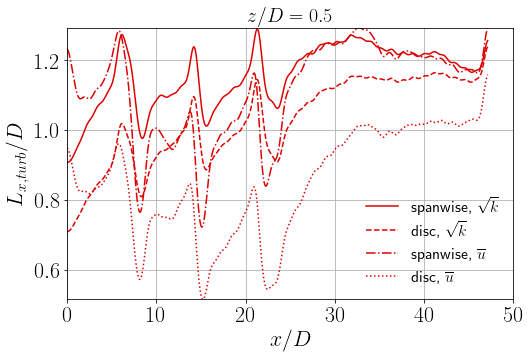

In [5]:
### Sensitivity two different definitions ###
#############################################

### Test it for disc averaged vs spanwise averaged ###
######################################################

import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams.update({'font.size': 22})

from matplotlib import rc
rc('text', usetex=True)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

#############
x = np.linspace(0.0,6.0*np.pi,Nx) ## x location
##############
eps = 1e-4
Lturb = np.sqrt(2/3)*tke**1.5/(diss+eps)
Lturb2 = 0.1*uavg*tke/(diss+eps)
Lturbd = np.sqrt(2/3)*tke_disc**1.5/(diss_disc+eps)
Lturbd2 = 0.1*uavg_disc*tke_disc/(diss_disc+eps)

D = 0.4

xx_list = [50,80,100,140,180,200]
colors = [plt.cm.hot(xx) for xx in xx_list] #['red','blue','green','magenta','black','lime']

linestyle = ['-','--','-.',':']
linewidth = [3.0,3.0,3.0,6.0]

fig1 = plt.figure(figsize=(8,5))

k=2
plt.plot(x/D,Lturb[1,k,:],color=colors[1],linestyle=linestyle[0],label='spanwise, $\sqrt{k}$')
plt.plot(x/D,Lturb2[1,k,:],color=colors[1],linestyle=linestyle[1],label='disc, $\sqrt{k}$')
plt.plot(x/D,Lturbd[1,k,:],color=colors[1],linestyle=linestyle[2],label='spanwise, $\overline{u}$')
plt.plot(x/D,Lturbd2[1,k,:],color=colors[1],linestyle=linestyle[3],label='disc, $\overline{u}$')

Lmin = np.min([np.min(Lturb[1,k,:]),np.min(Lturb2[1,k,:]),np.min(Lturbd[1,k,:]),np.min(Lturbd2[1,k,:])])
Lmax = np.max([np.max(Lturb[1,k,:]),np.max(Lturb2[1,k,:]),np.max(Lturbd[1,k,:]),np.max(Lturbd2[1,k,:])])

plt.xlim([0,50])
plt.ylim([Lmin,Lmax])
plt.xlabel(r'$x/D$')
plt.ylabel(r'$L_{x,turb}/D$')
plt.grid(True)
plt.legend(loc='best',frameon=False,fontsize=16)
plt.title('$z/D=%2.1f$'%yD[k],fontsize=20)


